extra question

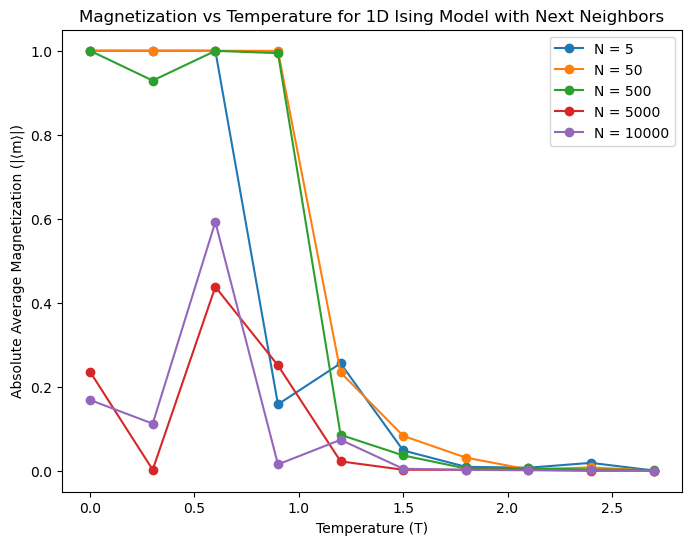

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

# 1. Initialize the lattice with random spin states (Numba-compatible approach)
@nb.njit
def initialize_lattice(N):
    lattice = np.zeros(N, dtype=np.int32)
    for i in range(N):
        # Randomly choose -1 or 1
        lattice[i] = 1 if np.random.randint(0, 2) == 1 else -1
    return lattice

# Use the Metropolis algorithm accelerated by Numba to update the lattice, including next-nearest neighbor interactions
@nb.njit
def metropolis_step_with_next_neighbors(lattice, J, T):
    N = lattice.size
    for i in range(N):
        # Randomly choose a spin
        site = np.random.randint(0, N)
        
        # Calculate the energy difference: nearest neighbors
        delta_E = 2 * J * lattice[site] * (lattice[(site - 1) % N] + lattice[(site + 1) % N])
        
        # Add the energy difference for next-nearest neighbors
        delta_E += 2 * J * lattice[site] * (lattice[(site - 2) % N] + lattice[(site + 2) % N])
        
        # Metropolis algorithm: accept or reject spin flip
        if delta_E < 0 or np.random.rand() < np.exp(-delta_E / T):
            lattice[site] = -lattice[site]
            
    return lattice

# Monte Carlo simulation with magnetization tracking, including next-nearest neighbor interactions
@nb.njit
def ising_simulation_with_magnetization_tracking(N, J, T, n_steps):
    lattice = initialize_lattice(N)
    magnetization_list = np.zeros(n_steps)  # Use NumPy array instead of list
    
    for step in range(n_steps):
        # Metropolis step
        lattice = metropolis_step_with_next_neighbors(lattice, J, T)
        
        # Calculate average spin of the current lattice
        magnetization = np.sum(lattice) / N
        magnetization_list[step] = magnetization  # Record magnetization
    
    return magnetization_list

# Average spin calculation at equilibrium, including next-nearest neighbor interactions
@nb.njit
def ising_simulation(N, J, T, n_steps, n0):
    lattice = initialize_lattice(N)
    magnetization_list = np.zeros(n_steps)
    
    for step in range(n_steps):
        # Metropolis step
        lattice = metropolis_step_with_next_neighbors(lattice, J, T)
        
        # Calculate average spin of the current lattice
        magnetization = np.sum(lattice) / N
        magnetization_list[step] = magnetization
    
    # Only calculate equilibrium average spin for n > n0
    if n_steps > n0:
        return np.abs(np.mean(magnetization_list[n0:]))  # Take the absolute value and compute from n0 onwards
    else:
        return np.abs(np.mean(magnetization_list))

# Parallel simulation for systems at different temperatures
@nb.njit(parallel=True)
def simulate_multiple_temperatures(N, J, T_values, n_steps, n0):
    avg_magnetizations = np.zeros(len(T_values))
    
    for i in nb.prange(len(T_values)):  # Process temperatures in parallel
        T = T_values[i]
        avg_magnetization = ising_simulation(N, J, T, n_steps, n0)
        avg_magnetizations[i] = avg_magnetization
    
    return avg_magnetizations

# Parallel simulation for different values of N, where N_values is a NumPy array
@nb.njit(parallel=True)
def simulate_for_different_N(J, T_values, n_steps, n0, N_values):
    # Pre-create the magnetization arrays for all N
    all_avg_magnetizations = np.zeros((len(N_values), len(T_values)))

    # Parallel computation for different N
    for i in nb.prange(len(N_values)):
        N = N_values[i]
        avg_magnetizations = simulate_multiple_temperatures(N, J, T_values, n_steps, n0)
        all_avg_magnetizations[i, :] = avg_magnetizations
    
    return all_avg_magnetizations

# Plot magnetization vs temperature curves for different N values (not Numba-compatible, needs to be outside)
def plot_magnetization_vs_temperature_for_different_N(T_values, all_avg_magnetizations, N_values):
    plt.figure(figsize=(8, 6))
    
    for i, N in enumerate(N_values):
        plt.plot(T_values, all_avg_magnetizations[i, :], 'o-', label=f'N = {N}')
    
    plt.xlabel('Temperature (T)')
    plt.ylabel('Absolute Average Magnetization (|⟨m⟩|)')
    plt.title('Magnetization vs Temperature for 1D Ising Model with Next Neighbors')
    plt.legend()
    plt.show()


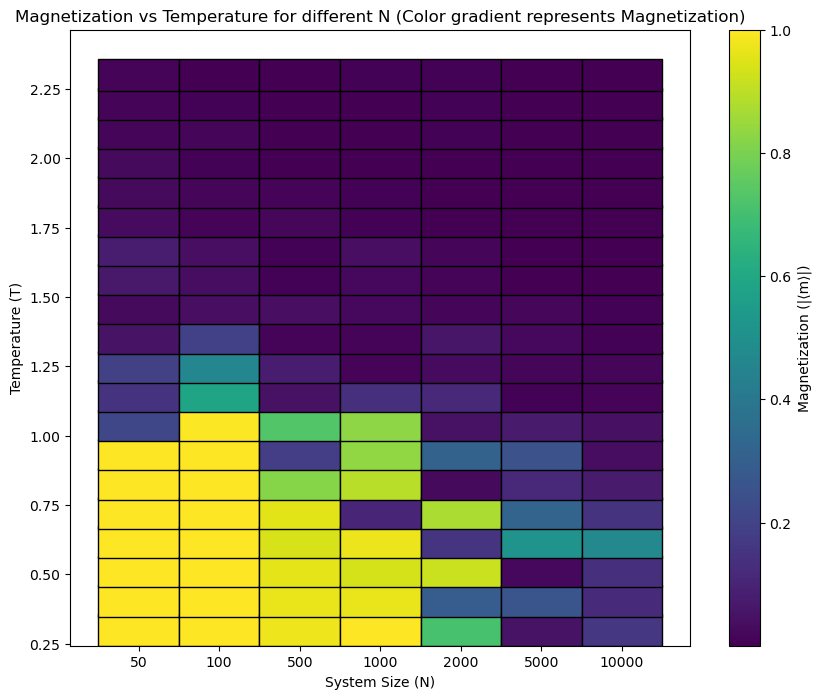

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm  # Import the color mapping module

# Plot standard bar blocks for different N values, where each block's color reflects the magnetization
def plot_magnetization_blocks(T_values, all_avg_magnetizations, N_values):
    # Create a color mapping object to reflect the variation of magnetization with temperature
    norm = mcolors.Normalize(vmin=np.min(all_avg_magnetizations), vmax=np.max(all_avg_magnetizations))
    cmap = cm.viridis  # Use the Viridis color map

    fig, ax = plt.subplots(figsize=(10, 8))  # Create a new axis object

    num_N = len(N_values)
    height = 0.8 / num_N  # Height of each bar

    for i, N in enumerate(N_values):
        # Retrieve magnetization data
        magnetizations = all_avg_magnetizations[i, :]

        # For each N, plot a set of standard rectangular blocks, with color based on magnetization
        for j, T in enumerate(T_values):
            ax.bar(i, height=height, width=1.0, bottom=T - height/2,
                   color=cmap(norm(magnetizations[j])), edgecolor='black')

    ax.set_ylabel('Temperature (T)')
    ax.set_title('Magnetization vs Temperature for different N (Color gradient represents Magnetization)')
    
    # Use cm.ScalarMappable to generate a color bar, representing the magnitude of magnetization
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Magnetization (|⟨m⟩|)")
    
    ax.set_xticks(range(len(N_values)))
    ax.set_xticklabels([f'{N}' for N in N_values])
    ax.set_xlabel('System Size (N)')
    plt.show()

# Parameter setup
N_values = np.array([50,100,500,1000,2000,5000,10000])  # Convert N_values to a NumPy array
J = 1.0  # Exchange constant
T_values = np.linspace(0.3, 2.3, 20)  # Temperature range
n_steps = 100000  # Total number of simulation steps (nmax)
n0 = 1000  # Number of steps before stability is assumed, treated as transient

# Step 2: After determining n0, simulate the equilibrium average spin for multiple temperatures, and simulate for different system sizes N
all_avg_magnetizations = simulate_for_different_N(J, T_values, n_steps, n0, N_values)

# Plot standard bar blocks for different N values, where each block's color reflects the magnetization
plot_magnetization_blocks(T_values, all_avg_magnetizations, N_values)
